## Importando bibliotecas

In [49]:
# !pip -q install yfinance

In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

import plotly.express as px

## Coleta de dados 

Coletando dados históricos da ação Disney (DIS) de 2018 até 2024. Focando no preço de fechamento ('Close').

In [2]:
symbol = 'DIS'
start_date = '2018-01-01'  # Data de início
end_date = '2024-07-20'  # Data de fim

# Download dos dados históricos
df = yf.download(symbol, start=start_date, end=end_date)
data = df[['Close']]  # Usando apenas o preço de fechamento


[*********************100%***********************]  1 of 1 completed


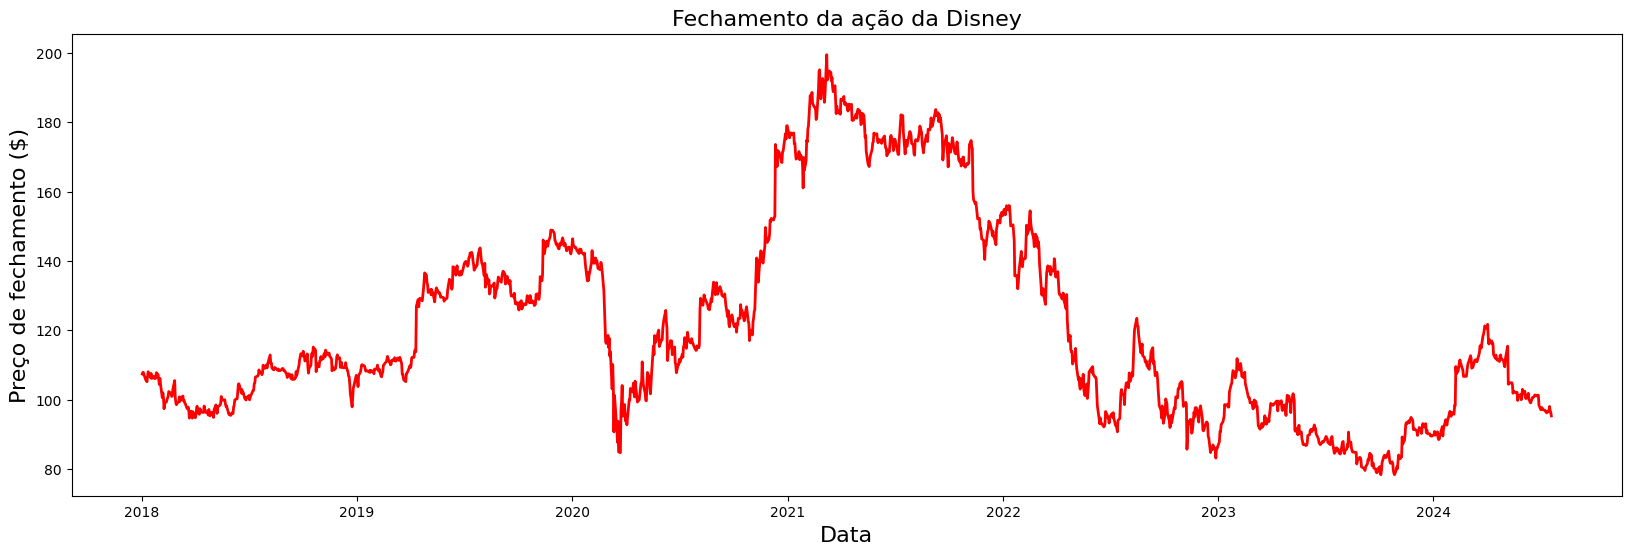

In [20]:
plt.figure(figsize=(20,6))
plt.plot(data['Close'].index, data['Close'], lw=2, color='r')
plt.xlabel("Data", fontsize=16)
plt.ylabel("Preço de fechamento ($)", fontsize=16)
plt.title("Fechamento da ação da Disney", fontsize=16)

plt.show()

De acordo com o gráfico podemos ver a evolução histórica do preço de fechamento das ações da Disney (DIS) de 2018 até 2024. Entre 2018 e 2019 podemos ver um período relativamente estável, em 2020 uma grande queda provavelmente associado a pandemia COVID-19 (março/2020). Em 2021 teve uma forte recuperação, atingindo um pico de 200. E entre 2022-2024 tem uma tendência de queda, com preços voltando aos níveis de 2018.

## Processamento de dados

In [15]:
# Normalizando os dados numa escala entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))  
data_scaled = data.copy()
data_scaled['Close'] = scaler.fit_transform(data_scaled['Close'])

In [16]:
# Divisão entre treino (80%) e teste (20%)
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size].reset_index()
test_data = data_scaled[train_size:].reset_index()

In [17]:
train_data

Price,Date,Close
Ticker,,DIS
0,2018-01-02,0.239873
1,2018-01-03,0.243681
2,2018-01-04,0.243284
3,2018-01-05,0.238445
4,2018-01-08,0.225752
...,...,...
1312,2023-03-21,0.140468
1313,2023-03-22,0.127090
1314,2023-03-23,0.134677


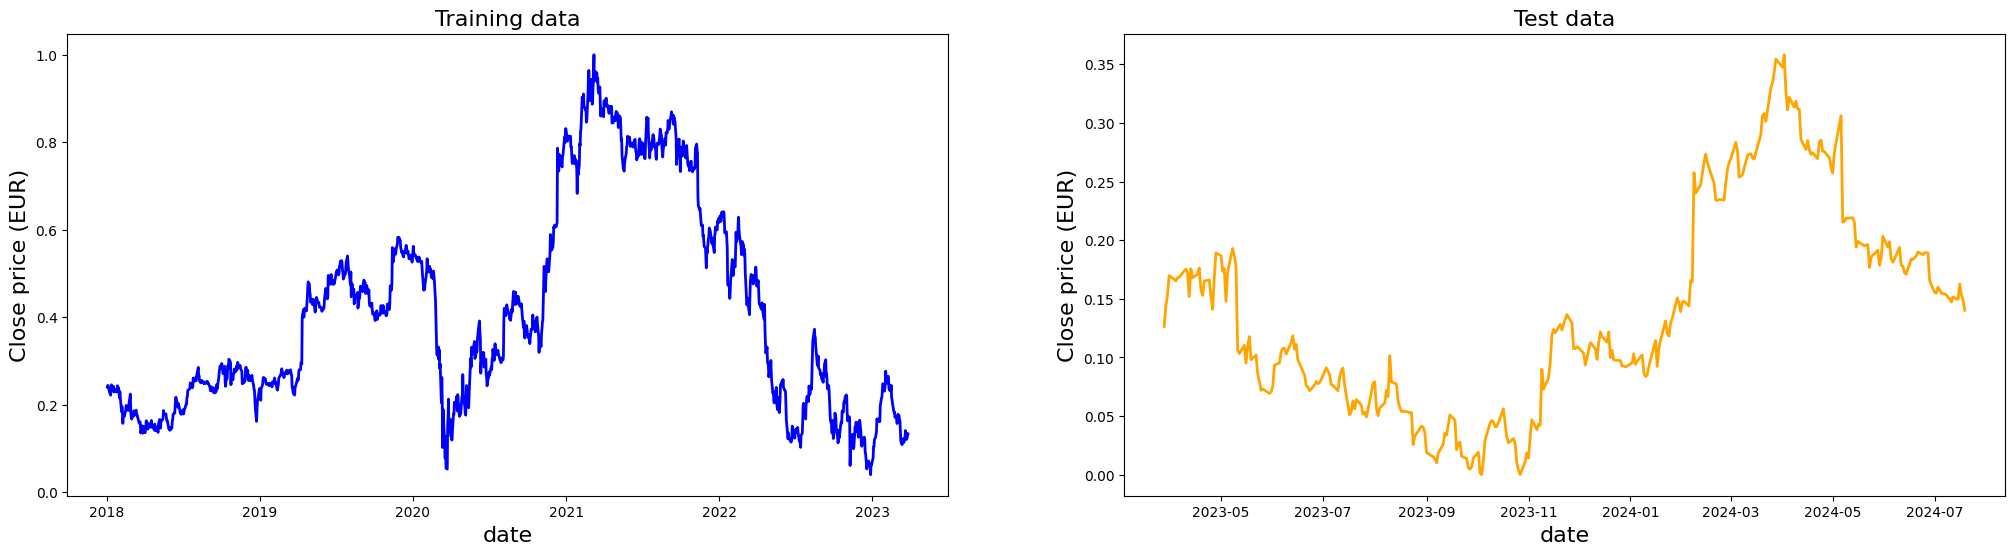

In [37]:
# Gráficos pra visualizar como os dados de treino e teste estão divididos

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data.Date, train_data['Close'], c='blue', lw=2)
ax1.set_xlabel("date", fontsize=16)
ax1.set_ylabel("Close price (EUR)", fontsize=16)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data.Date, test_data['Close'], c='orange', lw=2)
ax2.set_xlabel("date", fontsize=16)
ax2.set_ylabel("Close price (EUR)", fontsize=16)
ax2.set_title("Test data", fontsize=16);

# Treinando o modelo LSTM

In [26]:
# Função para criar sequências temporais para LSTM
# Cria janelas deslizantes de 60 dias
# Para cada sequência de 60 dias (X) o valor do 61 dia é o alvo(y)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [27]:
train_data_np = train_data['Close'].values.reshape(-1, 1)
test_data_np = test_data['Close'].values.reshape(-1, 1)

In [39]:
time_step = 30  # Número de passos temporais
X_train, y_train = create_sequences(train_data_np, time_step)
X_test, y_test = create_sequences(test_data_np, time_step)

# Ajustando o formato para [amostras, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. Construção do Modelo LSTM
model = Sequential([
    #Primeira camada: processa sequências de 60 dias
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # Regularização para evitar overfitting

    #Segunda camada
    LSTM(100, return_sequences=False),  # Segunda camada LSTM
    Dropout(0.2),

    Dense(25),  # Camada densa intermediária
    Dense(1)  # Camada de saída para previsão do valor
])

model.compile(optimizer='adam', loss='mean_squared_error')  # Compilação do modelo

# 4. Treinamento
history = model.fit(
    X_train, y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    verbose=1
)

# 5. Avaliação
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0770 - val_loss: 0.0090
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - val_loss: 6.9334e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - val_loss: 7.1020e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026 - val_loss: 7.8890e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0028 - val_loss: 9.0628e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0029 - val_loss: 7.8430e-04
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026 - val_loss: 7.1494e-04
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023 - val_loss: 5.7349e-04
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 5.7465e-04
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020 - val_loss: 6.3681e-04
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━

In [40]:
# Revertendo a normalização
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [41]:
# Cálculo das métricas
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

train_mae, train_rmse, train_mape, train_r2 = calculate_metrics(y_train_actual, train_predictions)
test_mae, test_rmse, test_mape, test_r2 = calculate_metrics(y_test_actual, test_predictions)

print(f"Treinamento - MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}, MAPE: {train_mape:.2f}%, R2: {train_r2:.2f}")
print(f"Teste - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape:.2f}%, R2: {test_r2:.2F}")

Treinamento - MAE: 2.34, RMSE: 3.31, MAPE: 1.88%, R2: 0.99
Teste - MAE: 1.56, RMSE: 2.15, MAPE: 1.64%, R2: 0.96


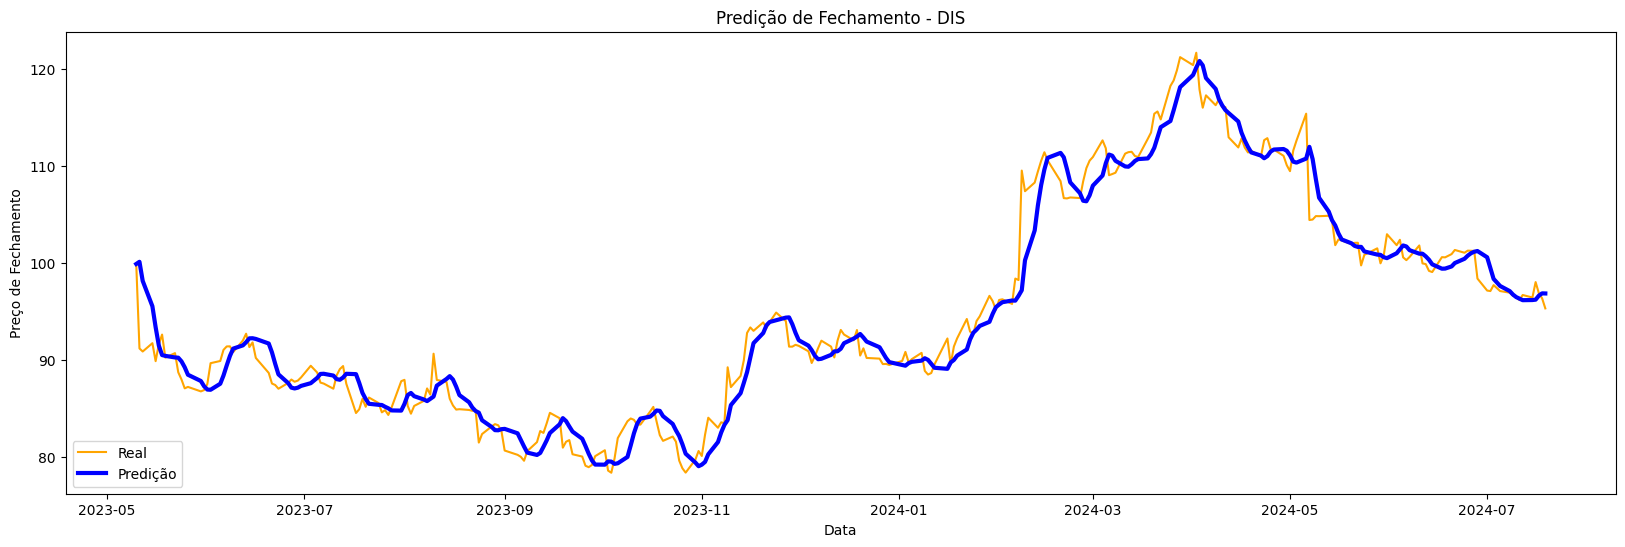

In [42]:
# 6. Visualização
plt.figure(figsize=(20, 6))
plt.plot(data.index[train_size + time_step:], y_test_actual, label='Real', c='orange')
plt.plot(data.index[train_size + time_step:], test_predictions, label='Predição', c='blue', lw=3, linestyle = '-')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title(f'Predição de Fechamento - {symbol}')
plt.legend(loc="lower left")
plt.show()

O modelo parece estar acompanhando bem a tendência real dos preços. As linhas azul (previsão) e laranja (real) estão muito próximas. Isso confirma o alto R2 (0.96) que vimos nas métricas.


O primeiro teste que fizemos foi considerando `time_steps` igual 60 e LSTM units igual a 50 e obtemos resultados inferiores. 

## Salvando modelo

In [ ]:
# 7. Salvar o Modelo
model.save('modelo_lstm_predicao_acoes.h5')
print("Modelo salvo como 'modelo_lstm_predicao_acoes.h5'")

## Inferência

In [ ]:
# # 8. Carregar o Modelo para Inferência
# modelo_carregado = load_model('modelo_lstm_predicao_acoes.h5')
# print("Modelo carregado com sucesso.")

# # Fazer uma previsão com o modelo carregado (opcional)
# novas_predicoes = modelo_carregado.predict(X_test)
# novas_predicoes = scaler.inverse_transform(novas_predicoes)

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(data.index[train_size + time_step:], y_test_actual, label='Real')
# plt.plot(data.index[train_size + time_step:], novas_predicoes, label='Predição (Modelo Carregado)')
# plt.xlabel('Data')
# plt.ylabel('Preço de Fechamento')
# plt.title(f'Predição com Modelo Carregado - {symbol}')
# plt.legend()
# plt.show()

# Sugestão para testar

Testar combinações de time steps com lstm units.

In [ ]:
# # Teste diferentes combinações
# time_steps = [20, 30, 40, 50, 60]
# lstm_units = [50, 100, 150]

# for steps in time_steps:
#     for units in lstm_units:
#         model = create_model(steps, units)
#         # Treinar e avaliar
#         # Comparar resultados